# SAR Iceberg Classifier - Milestones 1 & 2
## Fall AI Studio Challenge Project
## Authored by: Colin J. Emmanuel

**Objective**: Test open source computer vision foundation models on SAR imagery classification

**Dataset**: Statoil/C-CORE Iceberg Classifier Challenge
- 1,604 training images (75x75x2 channels)
- 8,424 test images
- Binary classification: Ship vs Iceberg

## Setup and Imports

In [6]:
# Install required packages (skipping TensorFlow to avoid version conflicts)
!pip install pandas numpy matplotlib seaborn scikit-learn transformers torch torchvision pillow umap-learn joblib

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
import json
import pickle
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Using scikit-learn instead of TensorFlow (simpler, no version conflicts)
print("✅ Using scikit-learn MLPClassifier for baseline model")
print("   (Avoids TensorFlow/protobuf version conflicts)")

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("\nSetup complete!")

Matplotlib is building the font cache; this may take a moment.


✅ Using scikit-learn MLPClassifier for baseline model
   (Avoids TensorFlow/protobuf version conflicts)

Setup complete!


## Milestone 1: Exploratory Data Analysis & Baseline Model

### 1.1 Load and Explore Data

In [8]:
# Load the data
# Note: Download from Kaggle and place in the same directory
# https://www.kaggle.com/competitions/statoil-iceberg-classifier-challenge/data

train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print("\nTraining set columns:")
print(train_df.columns.tolist())
print("\nFirst few rows:")
train_df.head()

Training set shape: (1604, 5)
Test set shape: (8424, 4)

Training set columns:
['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg']

First few rows:


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [9]:
# Basic statistics
print("Dataset Info:")
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"\nClass distribution in training set:")
print(train_df['is_iceberg'].value_counts())
print(f"\nClass balance: {train_df['is_iceberg'].value_counts(normalize=True)}")
print(f"\nMissing inc_angle values in train: {train_df['inc_angle'].isna().sum()}")
print(f"Missing inc_angle values in test: {test_df['inc_angle'].isna().sum()}")

Dataset Info:
Total training samples: 1604
Total test samples: 8424

Class distribution in training set:
is_iceberg
0    851
1    753
Name: count, dtype: int64

Class balance: is_iceberg
0    0.530549
1    0.469451
Name: proportion, dtype: float64

Missing inc_angle values in train: 0
Missing inc_angle values in test: 0


### 1.2 Understanding SAR Imagery

**Synthetic Aperture Radar (SAR)**:
- Uses microwave radar to create 2D/3D images
- Works day/night and through clouds
- Two channels (bands): HH and HV polarization
  - **HH**: Horizontal transmit, Horizontal receive
  - **HV**: Horizontal transmit, Vertical receive
- **inc_angle**: Incidence angle affects radar return intensity
- Ships and icebergs have different radar signatures

### 1.3 Data Preprocessing

In [10]:
# Convert band data to numpy arrays
def process_data(df):
    """Convert JSON band data to proper numpy arrays"""
    band1 = np.array([np.array(band).reshape(75, 75) for band in df['band_1']])
    band2 = np.array([np.array(band).reshape(75, 75) for band in df['band_2']])
    
    # Stack bands to create 2-channel images
    images = np.stack([band1, band2], axis=-1)  # Shape: (n_samples, 75, 75, 2)
    
    return images

X_train_raw = process_data(train_df)
X_test_raw = process_data(test_df)
y_train = train_df['is_iceberg'].values

print(f"X_train shape: {X_train_raw.shape}")
print(f"X_test shape: {X_test_raw.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1604, 75, 75, 2)
X_test shape: (8424, 75, 75, 2)
y_train shape: (1604,)


### 1.4 Exploratory Visualization

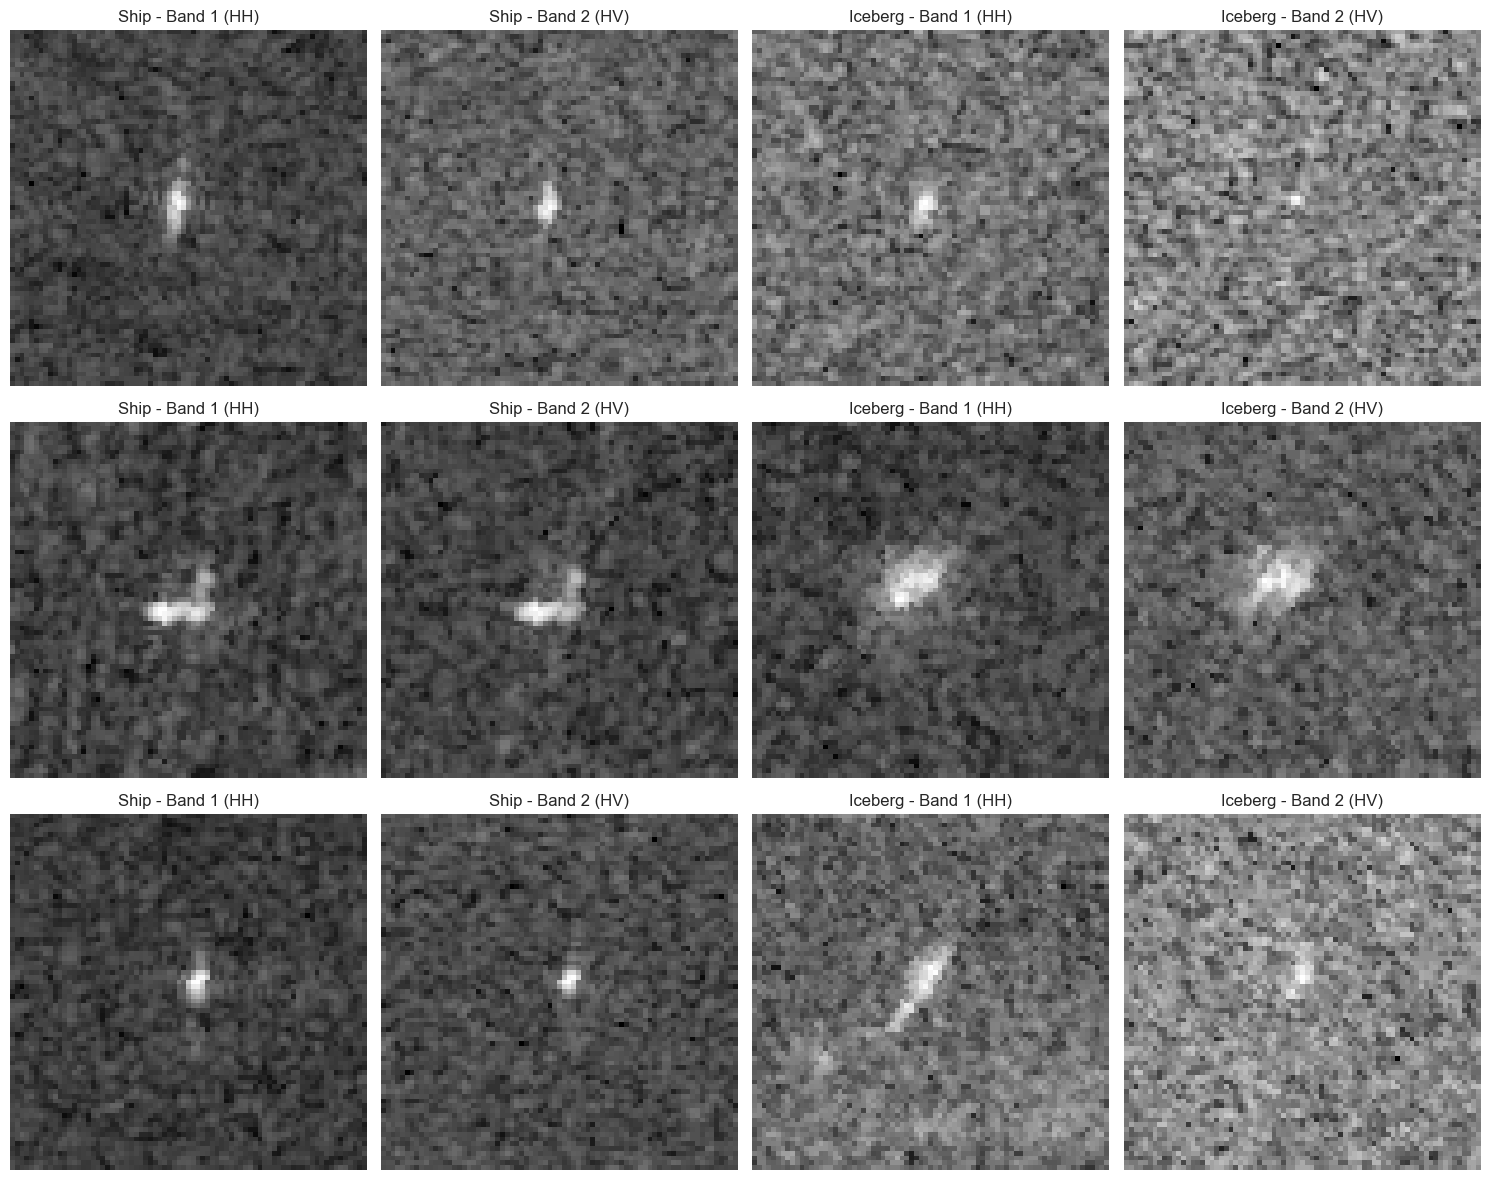

In [11]:
# Visualize sample images
fig, axes = plt.subplots(3, 4, figsize=(15, 12))

# Show ships
ship_indices = train_df[train_df['is_iceberg'] == 0].index[:6]
# Show icebergs
iceberg_indices = train_df[train_df['is_iceberg'] == 1].index[:6]

for idx, (i, label) in enumerate([(ship_indices, 'Ship'), (iceberg_indices, 'Iceberg')]):
    for j in range(3):
        sample_idx = i[j]
        
        # Band 1 (HH)
        axes[j, idx*2].imshow(X_train_raw[sample_idx, :, :, 0], cmap='gray')
        axes[j, idx*2].set_title(f'{label} - Band 1 (HH)')
        axes[j, idx*2].axis('off')
        
        # Band 2 (HV)
        axes[j, idx*2+1].imshow(X_train_raw[sample_idx, :, :, 1], cmap='gray')
        axes[j, idx*2+1].set_title(f'{label} - Band 2 (HV)')
        axes[j, idx*2+1].axis('off')

plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

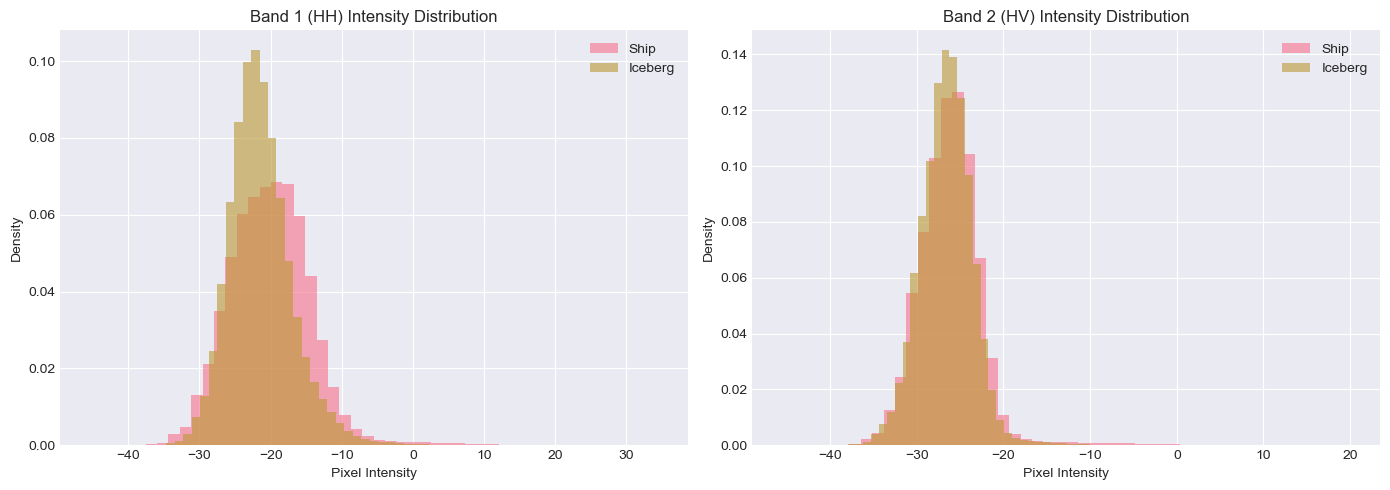

In [12]:
# Analyze pixel intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Band 1 distribution
ship_band1 = X_train_raw[y_train == 0, :, :, 0].flatten()
iceberg_band1 = X_train_raw[y_train == 1, :, :, 0].flatten()

axes[0].hist(ship_band1, bins=50, alpha=0.6, label='Ship', density=True)
axes[0].hist(iceberg_band1, bins=50, alpha=0.6, label='Iceberg', density=True)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Density')
axes[0].set_title('Band 1 (HH) Intensity Distribution')
axes[0].legend()

# Band 2 distribution
ship_band2 = X_train_raw[y_train == 0, :, :, 1].flatten()
iceberg_band2 = X_train_raw[y_train == 1, :, :, 1].flatten()

axes[1].hist(ship_band2, bins=50, alpha=0.6, label='Ship', density=True)
axes[1].hist(iceberg_band2, bins=50, alpha=0.6, label='Iceberg', density=True)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Density')
axes[1].set_title('Band 2 (HV) Intensity Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig('intensity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

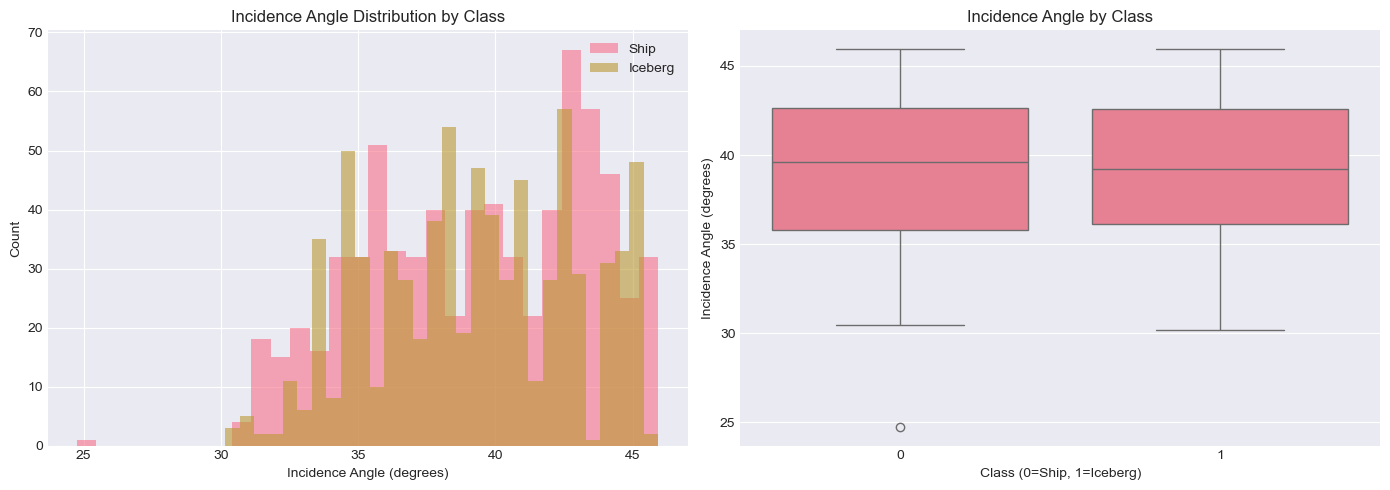


Missing inc_angle: 0 (0.0%)


In [13]:
# Analyze incidence angle
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Handle missing values
train_df_clean = train_df[train_df['inc_angle'] != 'na'].copy()
train_df_clean['inc_angle'] = train_df_clean['inc_angle'].astype(float)

# Distribution by class
ship_angles = train_df_clean[train_df_clean['is_iceberg'] == 0]['inc_angle']
iceberg_angles = train_df_clean[train_df_clean['is_iceberg'] == 1]['inc_angle']

axes[0].hist(ship_angles, bins=30, alpha=0.6, label='Ship')
axes[0].hist(iceberg_angles, bins=30, alpha=0.6, label='Iceberg')
axes[0].set_xlabel('Incidence Angle (degrees)')
axes[0].set_ylabel('Count')
axes[0].set_title('Incidence Angle Distribution by Class')
axes[0].legend()

# Box plot
sns.boxplot(data=train_df_clean, x='is_iceberg', y='inc_angle', ax=axes[1])
axes[1].set_xlabel('Class (0=Ship, 1=Iceberg)')
axes[1].set_ylabel('Incidence Angle (degrees)')
axes[1].set_title('Incidence Angle by Class')

plt.tight_layout()
plt.savefig('incidence_angle_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nMissing inc_angle: {train_df['inc_angle'].isna().sum()} ({100*train_df['inc_angle'].isna().mean():.1f}%)")

### 1.5 Prepare Data for Baseline Model

We'll use a simple MLP (Multi-Layer Perceptron) as our baseline model.

In [14]:
# Flatten images for MLP input
X_train_flat = X_train_raw.reshape(X_train_raw.shape[0], -1)  # Shape: (n_samples, 75*75*2)
X_test_flat = X_test_raw.reshape(X_test_raw.shape[0], -1)

# Normalize pixel values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# Create validation split (20% of training data)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"Training set: {X_tr.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test_scaled.shape}")
print(f"\nFeature dimension: {X_tr.shape[1]} (75x75x2 = {75*75*2})")

Training set: (1283, 11250)
Validation set: (321, 11250)
Test set: (8424, 11250)

Feature dimension: 11250 (75x75x2 = 11250)


### 1.6 Build and Train Baseline MLP Model

In [15]:
# Build MLP model using scikit-learn
# Similar architecture to TensorFlow version: 512 -> 256 -> 128 neurons

baseline_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=100,
    batch_size=32,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=15,
    random_state=42,
    verbose=True
)

print("Baseline MLP Model Configuration:")
print(f"  Hidden layers: {baseline_model.hidden_layer_sizes}")
print(f"  Activation: {baseline_model.activation}")
print(f"  Solver: {baseline_model.solver}")
print(f"  Learning rate: {baseline_model.learning_rate_init}")
print(f"  Max iterations: {baseline_model.max_iter}")
print(f"  Early stopping: {baseline_model.early_stopping}")
print("\nModel ready for training!")

Baseline MLP Model Configuration:
  Hidden layers: (512, 256, 128)
  Activation: relu
  Solver: adam
  Learning rate: 0.001
  Max iterations: 100
  Early stopping: True

Model ready for training!


In [16]:
# Train the model
print("Training baseline MLP model...")
print("This may take 5-10 minutes depending on your hardware.\n")

# Combine training and validation for scikit-learn (it handles split internally)
X_combined = np.vstack([X_tr, X_val])
y_combined = np.hstack([y_tr, y_val])

# Train the model
baseline_model.fit(X_combined, y_combined)

print("\n" + "="*60)
print("Training complete!")
print("="*60)
print(f"Number of iterations: {baseline_model.n_iter_}")
print(f"Loss: {baseline_model.loss_:.4f}")

# Save the model
joblib.dump(baseline_model, 'baseline_mlp_model.pkl')
print("\n✅ Model saved as 'baseline_mlp_model.pkl'")

Training baseline MLP model...
This may take 5-10 minutes depending on your hardware.

Iteration 1, loss = 1.69502115
Validation score: 0.619938
Iteration 2, loss = 0.74525050
Validation score: 0.753894
Iteration 3, loss = 0.26715988
Validation score: 0.732087
Iteration 4, loss = 0.70191367
Validation score: 0.582555
Iteration 5, loss = 0.51059184
Validation score: 0.753894
Iteration 6, loss = 0.61053360
Validation score: 0.660436
Iteration 7, loss = 1.12873037
Validation score: 0.672897
Iteration 8, loss = 0.74660932
Validation score: 0.763240
Iteration 9, loss = 0.16010048
Validation score: 0.781931
Iteration 10, loss = 0.04420402
Validation score: 0.769470
Iteration 11, loss = 0.01752735
Validation score: 0.741433
Iteration 12, loss = 0.07266305
Validation score: 0.747664
Iteration 13, loss = 0.03262128
Validation score: 0.785047
Iteration 14, loss = 0.22554399
Validation score: 0.728972
Iteration 15, loss = 0.06262258
Validation score: 0.766355
Iteration 16, loss = 0.01580229
Valid

### 1.7 Evaluate Baseline Model

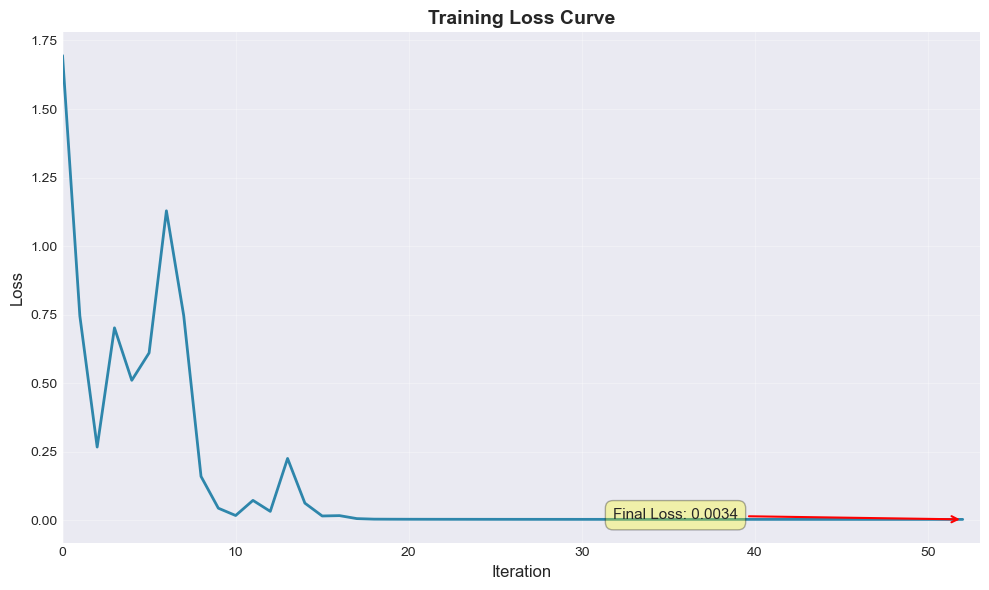

Training converged in 53 iterations
Final loss: 0.0034


In [17]:
# Plot training history (loss curve from scikit-learn)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot loss curve
ax.plot(baseline_model.loss_curve_, linewidth=2, color='#2E86AB')
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, len(baseline_model.loss_curve_))

# Add annotation
final_loss = baseline_model.loss_curve_[-1]
ax.annotate(f'Final Loss: {final_loss:.4f}',
            xy=(len(baseline_model.loss_curve_)-1, final_loss),
            xytext=(len(baseline_model.loss_curve_)*0.6, final_loss*1.2),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=11,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Training converged in {baseline_model.n_iter_} iterations")
print(f"Final loss: {final_loss:.4f}")


BASELINE MODEL PERFORMANCE ON VALIDATION SET
              precision    recall  f1-score   support

        Ship       0.98      0.95      0.96       170
     Iceberg       0.95      0.97      0.96       151

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321



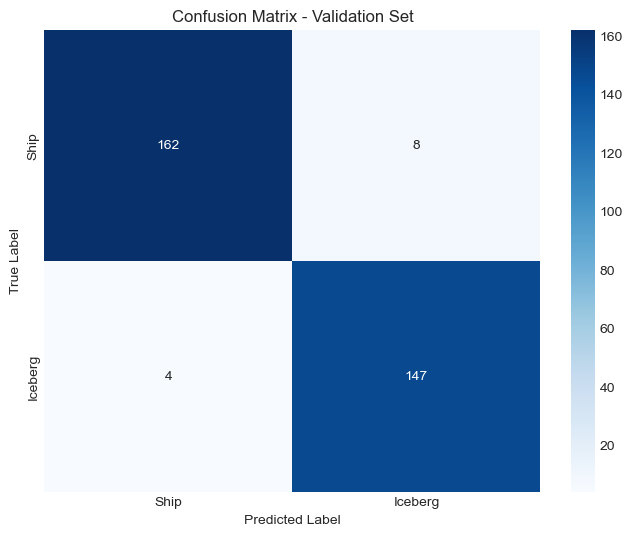


ROC-AUC Score: 0.9863


In [18]:
# Validation set predictions
y_val_pred_proba = baseline_model.predict_proba(X_val)[:, 1]  # Get probability of class 1 (iceberg)
y_val_pred = baseline_model.predict(X_val)

# Print classification report
print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE ON VALIDATION SET")
print("="*60)
print(classification_report(y_val, y_val_pred, target_names=['Ship', 'Iceberg']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ship', 'Iceberg'], 
            yticklabels=['Ship', 'Iceberg'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Validation Set')
plt.savefig('confusion_matrix_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC-AUC
auc = roc_auc_score(y_val, y_val_pred_proba)
print(f"\nROC-AUC Score: {auc:.4f}")

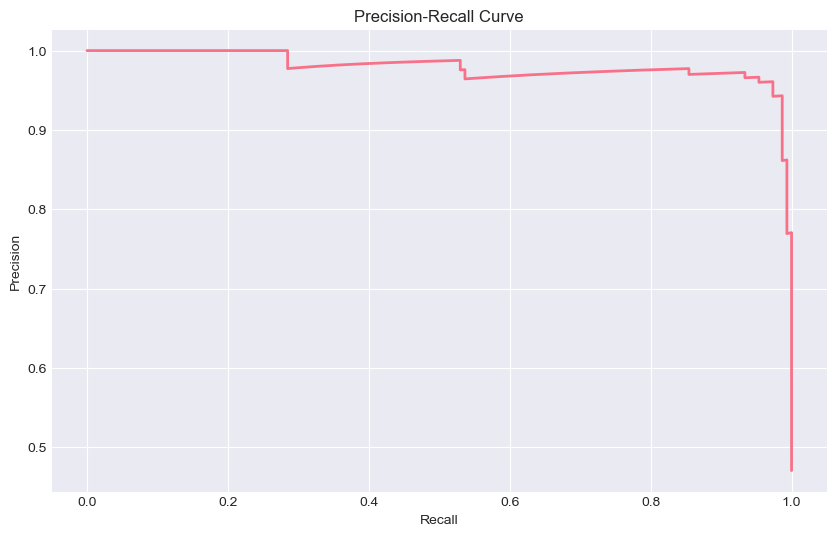

In [19]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

### 1.8 Analyze Errors and Successes


Total validation samples: 321
Errors: 12 (3.7%)
High confidence correct: 306


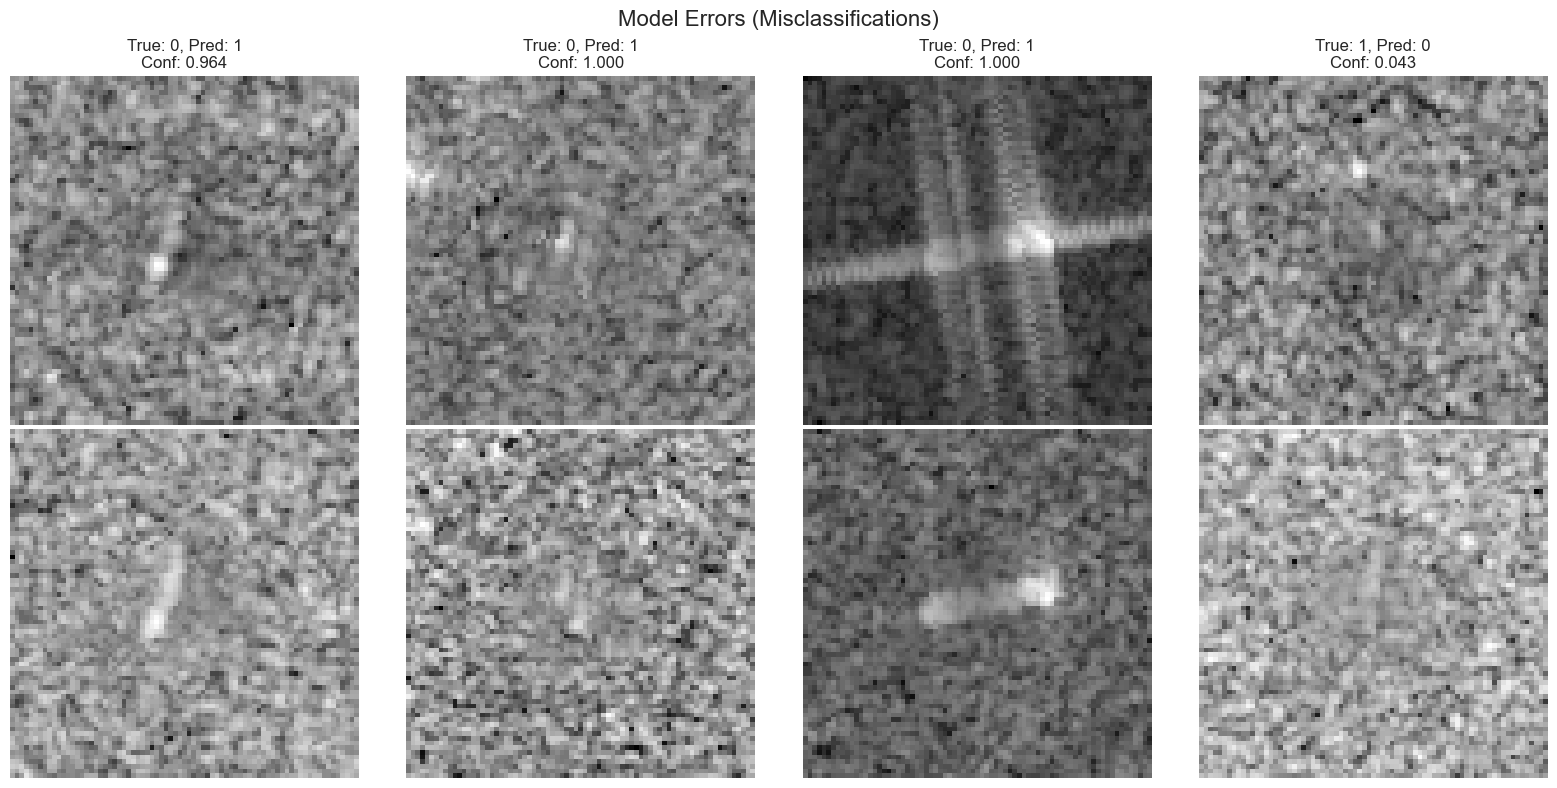

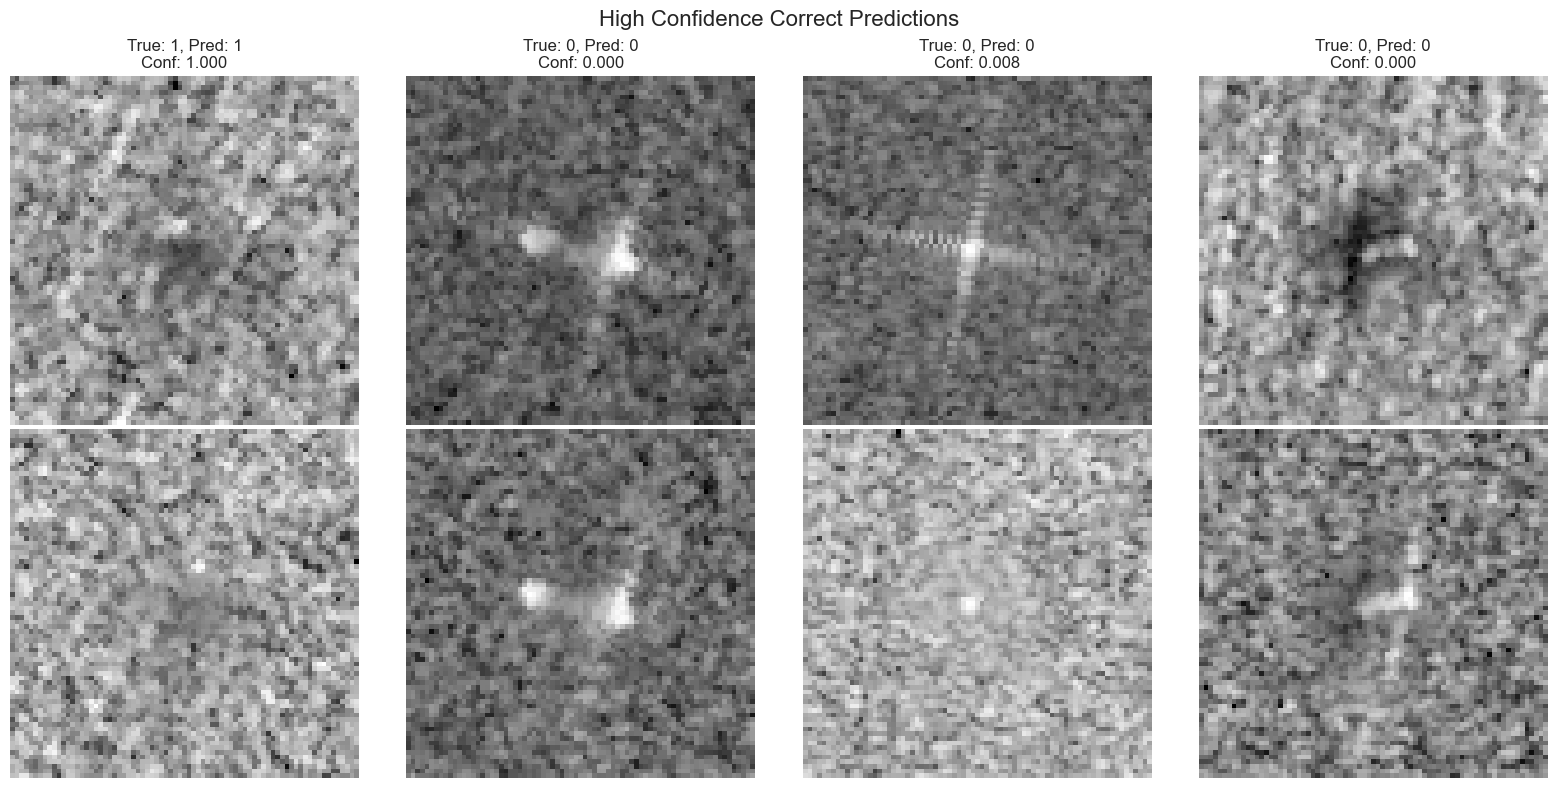

In [20]:
# Get validation set indices
val_indices = X_val.reshape(X_val.shape[0], 75, 75, 2)

# Find misclassified samples
errors = y_val != y_val_pred
error_indices = np.where(errors)[0]

# Find correctly classified samples with high confidence
correct = y_val == y_val_pred
high_conf_correct = np.where(correct & ((y_val_pred_proba > 0.9) | (y_val_pred_proba < 0.1)))[0]

print(f"\nTotal validation samples: {len(y_val)}")
print(f"Errors: {len(error_indices)} ({100*len(error_indices)/len(y_val):.1f}%)")
print(f"High confidence correct: {len(high_conf_correct)}")

# Visualize some errors
if len(error_indices) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Model Errors (Misclassifications)', fontsize=16)
    
    for i in range(min(4, len(error_indices))):
        idx = error_indices[i]
        
        # Band 1
        axes[0, i].imshow(val_indices[idx, :, :, 0], cmap='gray')
        axes[0, i].set_title(f'True: {y_val[idx]}, Pred: {y_val_pred[idx]}\nConf: {y_val_pred_proba[idx]:.3f}')
        axes[0, i].axis('off')
        
        # Band 2
        axes[1, i].imshow(val_indices[idx, :, :, 1], cmap='gray')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('model_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize some high-confidence correct predictions
if len(high_conf_correct) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('High Confidence Correct Predictions', fontsize=16)
    
    for i in range(min(4, len(high_conf_correct))):
        idx = high_conf_correct[i]
        
        # Band 1
        axes[0, i].imshow(val_indices[idx, :, :, 0], cmap='gray')
        axes[0, i].set_title(f'True: {y_val[idx]}, Pred: {y_val_pred[idx]}\nConf: {y_val_pred_proba[idx]:.3f}')
        axes[0, i].axis('off')
        
        # Band 2
        axes[1, i].imshow(val_indices[idx, :, :, 1], cmap='gray')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('high_confidence_correct.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
!pip install transformers torch torchvision pillow

## Milestone 2: Generate and Analyze Embeddings

### 2.1 Choose and Load Pre-trained Model

We'll use Vision Transformer (ViT) from HuggingFace - it's a strong foundation model for image tasks.

In [22]:
import transformers
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.57.1


In [23]:
import sys
import transformers

print(f"Python: {sys.executable}")
print(f"Transformers version: {transformers.__version__}")
print(f"Transformers location: {transformers.__file__}")

Python: /opt/anaconda3/envs/iceberg/bin/python
Transformers version: 4.57.1
Transformers location: /opt/anaconda3/envs/iceberg/lib/python3.10/site-packages/transformers/__init__.py


In [24]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import torch

# Load pre-trained ViT model and processor
model_name = 'google/vit-base-patch16-224-in21k'
print(f"Loading {model_name}...")

processor = AutoImageProcessor.from_pretrained(model_name)
vit_model = AutoModel.from_pretrained(model_name)

# Set to eval mode
vit_model.eval()

# Move to GPU if available (Mac M-series uses MPS, others use CUDA)
if torch.backends.mps.is_available():
    device = torch.device('mps')  # Mac M1/M2/M3
elif torch.cuda.is_available():
    device = torch.device('cuda')  # NVIDIA GPU
else:
    device = torch.device('cpu')

vit_model = vit_model.to(device)

print(f"\n✅ Using device: {device}")
print(f"✅ Model loaded: {model_name}")
print(f"✅ Expected embedding dimension: 768")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Loading google/vit-base-patch16-224-in21k...

✅ Using device: mps
✅ Model loaded: google/vit-base-patch16-224-in21k
✅ Expected embedding dimension: 768


### 2.2 Prepare SAR Images for ViT

ViT expects RGB images (3 channels), but we have 2-channel SAR data. We'll convert by creating a 3-channel representation.

Converting SAR images to RGB format...
Training RGB shape: (1604, 75, 75, 3)
Test RGB shape: (8424, 75, 75, 3)


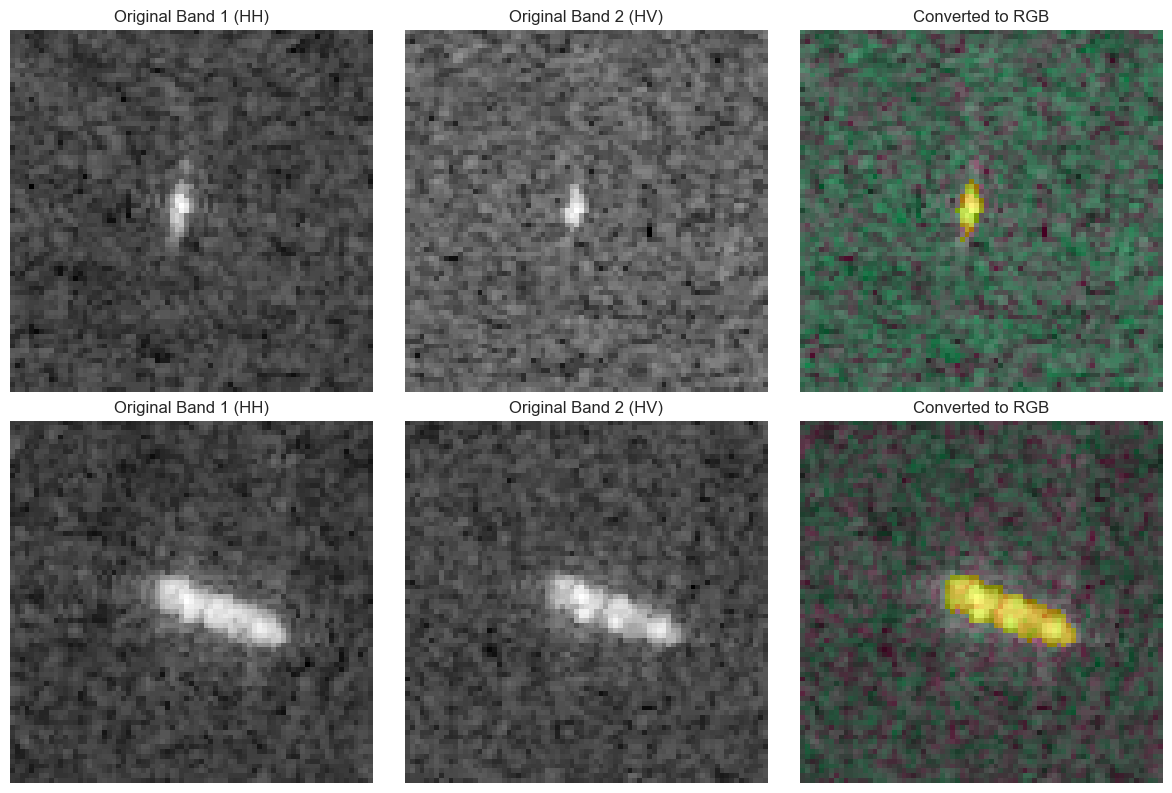

In [25]:
def prepare_sar_for_vit(sar_images):
    """
    Convert 2-channel SAR images to 3-channel RGB-like format for ViT.
    Strategy: Use band1 for R, band2 for G, and average for B.
    """
    n_samples = sar_images.shape[0]
    rgb_images = np.zeros((n_samples, 75, 75, 3))
    
    # Normalize to 0-255 range
    band1 = sar_images[:, :, :, 0]
    band2 = sar_images[:, :, :, 1]
    
    # Min-max normalization per image
    for i in range(n_samples):
        b1 = band1[i]
        b2 = band2[i]
        
        # Normalize to 0-255
        b1_norm = ((b1 - b1.min()) / (b1.max() - b1.min() + 1e-8) * 255).astype(np.uint8)
        b2_norm = ((b2 - b2.min()) / (b2.max() - b2.min() + 1e-8) * 255).astype(np.uint8)
        
        # Create 3-channel image
        rgb_images[i, :, :, 0] = b1_norm  # Red channel
        rgb_images[i, :, :, 1] = b2_norm  # Green channel
        rgb_images[i, :, :, 2] = (b1_norm + b2_norm) / 2  # Blue channel (average)
    
    return rgb_images.astype(np.uint8)

# Convert SAR images
print("Converting SAR images to RGB format...")
train_rgb = prepare_sar_for_vit(X_train_raw)
test_rgb = prepare_sar_for_vit(X_test_raw)

print(f"Training RGB shape: {train_rgb.shape}")
print(f"Test RGB shape: {test_rgb.shape}")

# Visualize conversion
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sample_idx = 0

axes[0, 0].imshow(X_train_raw[sample_idx, :, :, 0], cmap='gray')
axes[0, 0].set_title('Original Band 1 (HH)')
axes[0, 0].axis('off')

axes[0, 1].imshow(X_train_raw[sample_idx, :, :, 1], cmap='gray')
axes[0, 1].set_title('Original Band 2 (HV)')
axes[0, 1].axis('off')

axes[0, 2].imshow(train_rgb[sample_idx])
axes[0, 2].set_title('Converted to RGB')
axes[0, 2].axis('off')

sample_idx = 100
axes[1, 0].imshow(X_train_raw[sample_idx, :, :, 0], cmap='gray')
axes[1, 0].set_title('Original Band 1 (HH)')
axes[1, 0].axis('off')

axes[1, 1].imshow(X_train_raw[sample_idx, :, :, 1], cmap='gray')
axes[1, 1].set_title('Original Band 2 (HV)')
axes[1, 1].axis('off')

axes[1, 2].imshow(train_rgb[sample_idx])
axes[1, 2].set_title('Converted to RGB')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('sar_to_rgb_conversion.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
import sys
import transformers

print(f"Python: {sys.executable}")
print(f"Transformers version: {transformers.__version__}")
print(f"Transformers location: {transformers.__file__}")

Python: /opt/anaconda3/envs/iceberg/bin/python
Transformers version: 4.57.1
Transformers location: /opt/anaconda3/envs/iceberg/lib/python3.10/site-packages/transformers/__init__.py


### 2.3 Extract Embeddings from ViT

In [27]:
def extract_embeddings_batch(images, model, processor, batch_size=32, device='cpu'):
    """
    Extract embeddings from images using pre-trained ViT model.
    Uses batching for efficiency.
    """
    embeddings = []
    n_samples = len(images)
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = images[i:min(i+batch_size, n_samples)]
            
            # Convert to PIL Images
            pil_images = [Image.fromarray(img) for img in batch]
            
            # Process images
            inputs = processor(images=pil_images, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get embeddings (CLS token)
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            
            embeddings.append(batch_embeddings)
            
            if (i // batch_size) % 10 == 0:
                print(f"Processed {min(i+batch_size, n_samples)}/{n_samples} images...")
    
    return np.vstack(embeddings)

# Extract embeddings for training set
print("\nExtracting embeddings for training set...")
train_embeddings = extract_embeddings_batch(
    train_rgb, vit_model, processor, batch_size=32, device=device
)

# Extract embeddings for test set
print("\nExtracting embeddings for test set...")
test_embeddings = extract_embeddings_batch(
    test_rgb, vit_model, processor, batch_size=32, device=device
)

print(f"\nTrain embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")


Extracting embeddings for training set...
Processed 32/1604 images...
Processed 352/1604 images...
Processed 672/1604 images...
Processed 992/1604 images...
Processed 1312/1604 images...
Processed 1604/1604 images...

Extracting embeddings for test set...
Processed 32/8424 images...
Processed 352/8424 images...
Processed 672/8424 images...
Processed 992/8424 images...
Processed 1312/8424 images...
Processed 1632/8424 images...
Processed 1952/8424 images...
Processed 2272/8424 images...
Processed 2592/8424 images...
Processed 2912/8424 images...
Processed 3232/8424 images...
Processed 3552/8424 images...
Processed 3872/8424 images...
Processed 4192/8424 images...
Processed 4512/8424 images...
Processed 4832/8424 images...
Processed 5152/8424 images...
Processed 5472/8424 images...
Processed 5792/8424 images...
Processed 6112/8424 images...
Processed 6432/8424 images...
Processed 6752/8424 images...
Processed 7072/8424 images...
Processed 7392/8424 images...
Processed 7712/8424 images..

### 2.4 Save Embeddings

In [28]:
# Save embeddings and labels
np.save('train_embeddings_vit.npy', train_embeddings)
np.save('test_embeddings_vit.npy', test_embeddings)
np.save('train_labels.npy', y_train)

# Also save as pickle for easy loading
embedding_data = {
    'train_embeddings': train_embeddings,
    'test_embeddings': test_embeddings,
    'train_labels': y_train,
    'model_name': model_name
}

with open('embeddings_vit.pkl', 'wb') as f:
    pickle.dump(embedding_data, f)

print("Embeddings saved successfully!")
print("Files created:")
print("  - train_embeddings_vit.npy")
print("  - test_embeddings_vit.npy")
print("  - train_labels.npy")
print("  - embeddings_vit.pkl")

Embeddings saved successfully!
Files created:
  - train_embeddings_vit.npy
  - test_embeddings_vit.npy
  - train_labels.npy
  - embeddings_vit.pkl


### 2.5 Dimensionality Reduction and Visualization

We'll use Principal Component Analysis (PCA), t-Distributed Stochastic Neighbor Embedding (t-SNE), and Uniform Manifold Approximation (UMAP) to visualize the embeddings in 2D.

In [29]:
# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=2, random_state=42)
train_pca = pca.fit_transform(train_embeddings)

print(f"PCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Applying PCA...
PCA explained variance: [0.1989327 0.1263032]
Total variance explained: 0.3252


In [31]:
# Apply t-SNE
print("\nApplying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
train_tsne = tsne.fit_transform(train_embeddings)
print("t-SNE complete!")


Applying t-SNE...
t-SNE complete!


In [32]:
# Apply UMAP
try:
    import umap
    print("\nApplying UMAP...")
    umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    train_umap = umap_model.fit_transform(train_embeddings)
    print("UMAP complete!")
    has_umap = True
except ImportError:
    print("UMAP not available. Install with: pip install umap-learn")
    has_umap = False


Applying UMAP...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP complete!


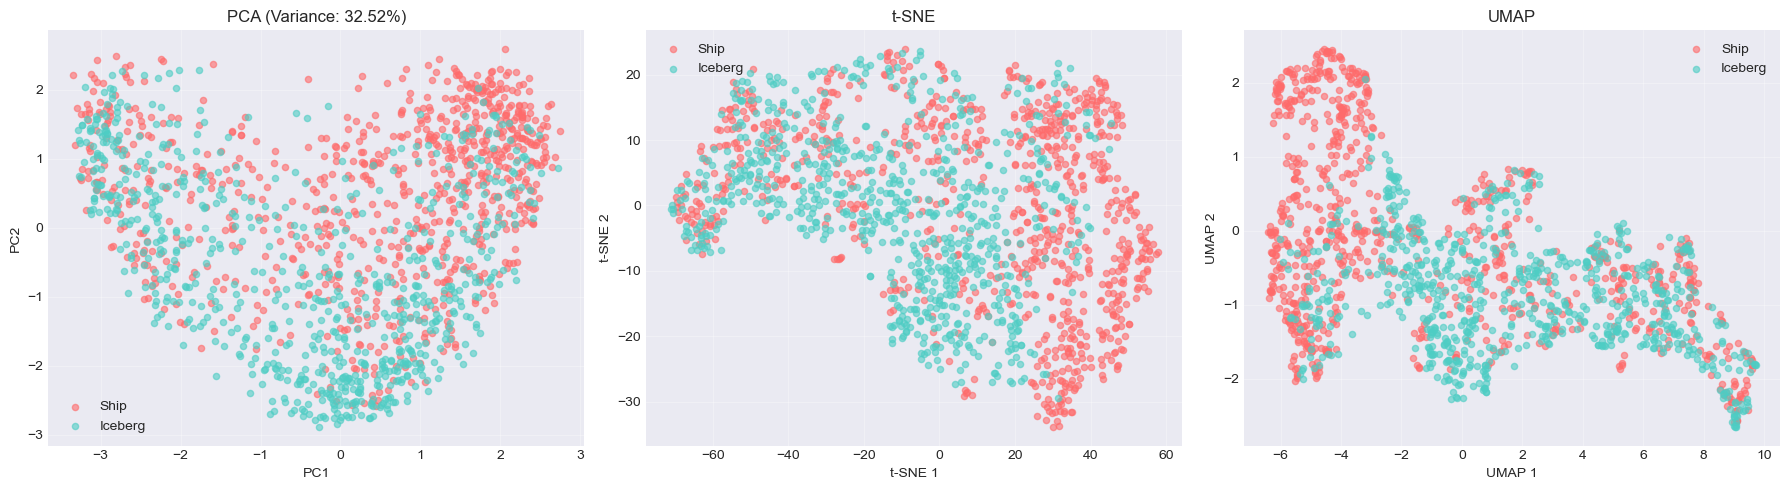

In [33]:
# Visualize embeddings
n_plots = 3 if has_umap else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

# Color map
colors = ['#FF6B6B', '#4ECDC4']  # Red for ship, teal for iceberg
labels_text = ['Ship', 'Iceberg']

# PCA plot
ax_idx = 0
for class_idx in [0, 1]:
    mask = y_train == class_idx
    axes[ax_idx].scatter(
        train_pca[mask, 0], 
        train_pca[mask, 1],
        c=colors[class_idx],
        label=labels_text[class_idx],
        alpha=0.6,
        s=20
    )
axes[ax_idx].set_xlabel('PC1')
axes[ax_idx].set_ylabel('PC2')
axes[ax_idx].set_title(f'PCA (Variance: {pca.explained_variance_ratio_.sum():.2%})')
axes[ax_idx].legend()
axes[ax_idx].grid(True, alpha=0.3)

# t-SNE plot
ax_idx = 1
for class_idx in [0, 1]:
    mask = y_train == class_idx
    axes[ax_idx].scatter(
        train_tsne[mask, 0], 
        train_tsne[mask, 1],
        c=colors[class_idx],
        label=labels_text[class_idx],
        alpha=0.6,
        s=20
    )
axes[ax_idx].set_xlabel('t-SNE 1')
axes[ax_idx].set_ylabel('t-SNE 2')
axes[ax_idx].set_title('t-SNE')
axes[ax_idx].legend()
axes[ax_idx].grid(True, alpha=0.3)

# UMAP plot
if has_umap:
    ax_idx = 2
    for class_idx in [0, 1]:
        mask = y_train == class_idx
        axes[ax_idx].scatter(
            train_umap[mask, 0], 
            train_umap[mask, 1],
            c=colors[class_idx],
            label=labels_text[class_idx],
            alpha=0.6,
            s=20
        )
    axes[ax_idx].set_xlabel('UMAP 1')
    axes[ax_idx].set_ylabel('UMAP 2')
    axes[ax_idx].set_title('UMAP')
    axes[ax_idx].legend()
    axes[ax_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embeddings_visualization_2d.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# Save dimensionality reduction results
dr_results = {
    'pca': train_pca,
    'tsne': train_tsne,
    'labels': y_train
}

if has_umap:
    dr_results['umap'] = train_umap

with open('dimensionality_reduction_results.pkl', 'wb') as f:
    pickle.dump(dr_results, f)

print("Dimensionality reduction results saved!")

Dimensionality reduction results saved!


### 2.6 Statistical Analysis of Embeddings

In [35]:
from scipy.stats import ttest_ind

# Separate embeddings by class
ship_embeddings = train_embeddings[y_train == 0]
iceberg_embeddings = train_embeddings[y_train == 1]

# Compute statistics
print("Embedding Statistics:")
print(f"Ship embeddings: {ship_embeddings.shape}")
print(f"Iceberg embeddings: {iceberg_embeddings.shape}")
print(f"\nShip mean magnitude: {np.linalg.norm(ship_embeddings.mean(axis=0)):.4f}")
print(f"Iceberg mean magnitude: {np.linalg.norm(iceberg_embeddings.mean(axis=0)):.4f}")

# Compute distances between classes
ship_centroid = ship_embeddings.mean(axis=0)
iceberg_centroid = iceberg_embeddings.mean(axis=0)
centroid_distance = np.linalg.norm(ship_centroid - iceberg_centroid)
print(f"\nDistance between class centroids: {centroid_distance:.4f}")

# Perform t-tests on first few principal components
print("\nt-test results for PCA components:")
ship_pca = train_pca[y_train == 0]
iceberg_pca = train_pca[y_train == 1]

for i in range(2):
    t_stat, p_value = ttest_ind(ship_pca[:, i], iceberg_pca[:, i])
    print(f"PC{i+1}: t={t_stat:.4f}, p={p_value:.4e}")

Embedding Statistics:
Ship embeddings: (851, 768)
Iceberg embeddings: (753, 768)

Ship mean magnitude: 3.7126
Iceberg mean magnitude: 3.9624

Distance between class centroids: 1.4890

t-test results for PCA components:
PC1: t=9.7010, p=1.1617e-21
PC2: t=17.8823, p=2.3790e-65


## Summary and Next Steps

### Milestone 1 Completed ✓
- Performed comprehensive EDA on SAR imagery dataset
- Built and trained baseline MLP model
- Achieved validation performance metrics
- Analyzed model errors and successes

### Milestone 2 Completed ✓
- Extracted embeddings using pre-trained ViT model
- Saved embeddings for future use
- Applied PCA, t-SNE, and UMAP for visualization
- Generated 2D visualizations showing class separation
- Performed statistical analysis

### For Next Presentation:
1. Train classifier on embeddings and compare to baseline
2. Try different foundation models (ResNet, EfficientNet, CLIP)
3. Fine-tune models on SAR data
4. Ensemble methods combining multiple embeddings

### Files Generated:
- `baseline_mlp_model.h5` - Trained baseline model
- `train_embeddings_vit.npy` - Training embeddings
- `test_embeddings_vit.npy` - Test embeddings
- `embeddings_vit.pkl` - All embeddings in one file
- Multiple visualization PNGs
- `dimensionality_reduction_results.pkl` - PCA/t-SNE/UMAP results